In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import csv
import random

REPO_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/newspaper-navigator-master/'

## description:

If you would like to use only the verified Beyond Words data, just disregard the headline and advertisement annotations, as well as the annotations for any image added after 12/1/2019.

Metadata are stored in file "/beyond_words_data/trainval.json". 

Images are inside "/beyond_words_data/images" directory.

## trainval.json:

In [2]:
with open(REPO_PATH + "/beyond_words_data/trainval.json") as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

In [3]:
jsonObject['info']

{'description': 'Beyond Words Dataset (verified)',
 'URL': 'http://beyondwords.labs.loc.gov/#/',
 'version': '1.0',
 'year': 2020,
 'contributor': 'LC Labs',
 'date_created': '03/17/2020'}

In [4]:
jsonObject['categories']

[{'id': 0, 'name': 'Photograph', 'supercategory': 'Content'},
 {'id': 1, 'name': 'Illustration', 'supercategory': 'Content'},
 {'id': 2, 'name': 'Map', 'supercategory': 'Content'},
 {'id': 3, 'name': 'Comics/Cartoon', 'supercategory': 'Content'},
 {'id': 4, 'name': 'Editorial Cartoon', 'supercategory': 'Content'},
 {'id': 5, 'name': 'Headline', 'supercategory': 'Content'},
 {'id': 6, 'name': 'Advertisement', 'supercategory': 'Content'}]

In [5]:
jsonObject['images'][562]

{'license': 1,
 'file_name': '563.jpg',
 'url': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/pst_greenberg_ver01/data/sn85038411/00296028290/1918032101/0097.jpg',
 'height': 1227,
 'width': 985,
 'date_captured': '12/1/2019',
 'id': 563}

### Random image:

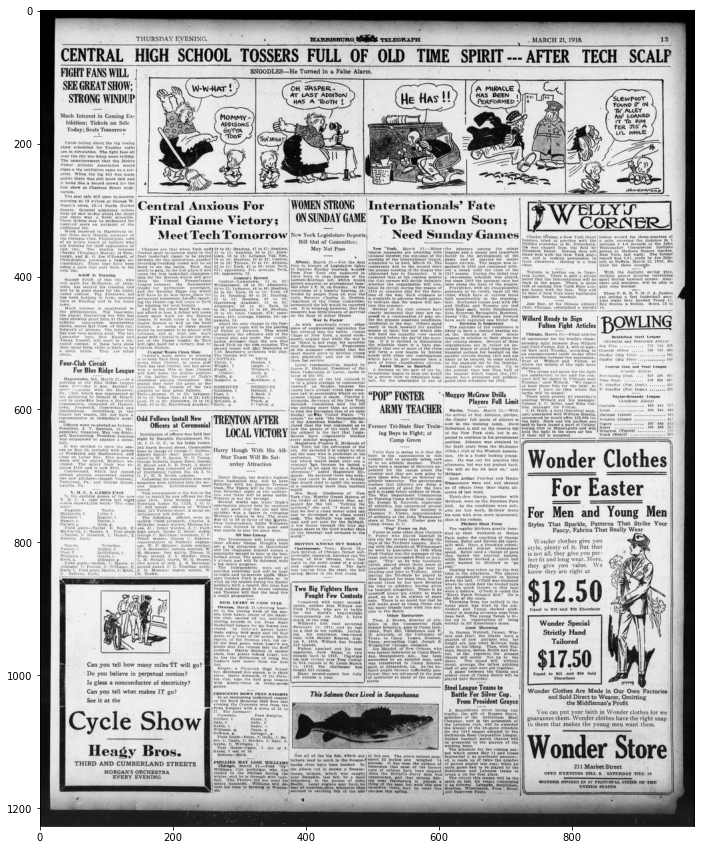

In [6]:
img = cv2.imread(REPO_PATH + 'beyond_words_data/images/563.jpg')

fig, ax = plt.subplots(figsize=(25, 15))
ax.imshow(img, cmap='gray')

## beyond_words.txt (file from their GitHub repository):

In [7]:
file = open(REPO_PATH + "beyond_words_data/beyond_words.txt", "r")

contents = file.read()
repo_dictionary = ast.literal_eval(contents)

file.close()

In [8]:
len(repo_dictionary['data'])

6753

In [9]:
# we have to find picture named '0097.jpg' in S3 url address
for i in range(len(repo_dictionary['data'])):
    if repo_dictionary['data'][i]['location']['standard'].split('/')[-1] == '0097.jpg':
        print(i)
        break

630


In [10]:
repo_dictionary['data'][630]

{'id': '5dbc66c3e8c9c8000100278a',
 'location': {'standard': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/pst_greenberg_ver01/data/sn85038411/00296028290/1918032101/0097.jpg'},
 'region': {'toolName': 'rectangleTool',
  'color': '#fe0000',
  'x': 2232.9839806563614,
  'y': 6082.426129080048,
  'width': 1408.5957355706114,
  'height': 1005.5406087908741,
  'label': 'Illustration/Photo'},
 'width': 5910,
 'height': 7362,
 'meta_data': {'set_key': 'http://chroniclingamerica.loc.gov/lccn/sn85038411/1918-03-21/ed-1/seq-13/',
  'subject_url': 'http://chroniclingamerica.loc.gov/lccn/sn85038411/1918-03-21/ed-1/seq-13/',
  'subject_description': 'Harrisburg telegraph. March 21, 1918. Page 13',
  'resize': '1.000000',
  'alto': 'http://s3.amazonaws.com/ndnp-batches/pst_greenberg_ver01/data/sn85038411/00296028290/1918032101/0097.xml'},
 'data': {'caption': "This Salmon Once Lived in Susquehanna\nNot all of the big fish, which our fathers used to catch in the Susquehanna river have been hooked. I

In [11]:
resized = cv2.resize(img, (5910, 7362))

box = cv2.rectangle(
    resized,
    (2232, 6082), # ['region']['x'], ['region']['y']
    (2232+1408, 6082+1005), # ['region']['x'] + ['region']['width'], ['region']['y'] + ['region']['height']
    (255, 0, 0), 
    thickness=25, 
)

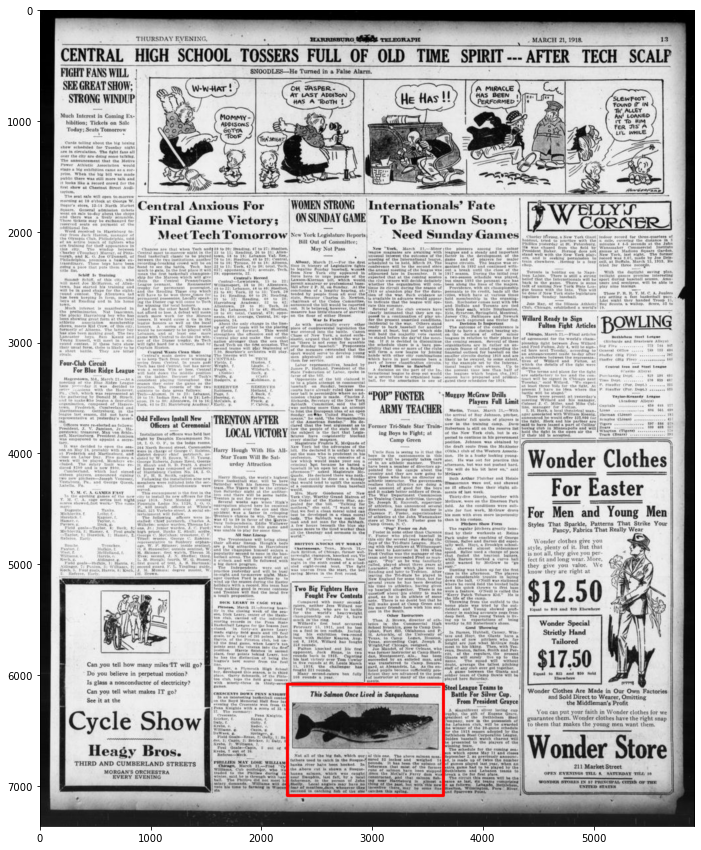

In [12]:
fig, ax = plt.subplots(figsize=(25, 15))
ax.imshow(box, cmap='gray')

In [13]:
# let's try to use default (after image reading) size and rescale coordinates instead of image size
img.shape

(1227, 985, 3)

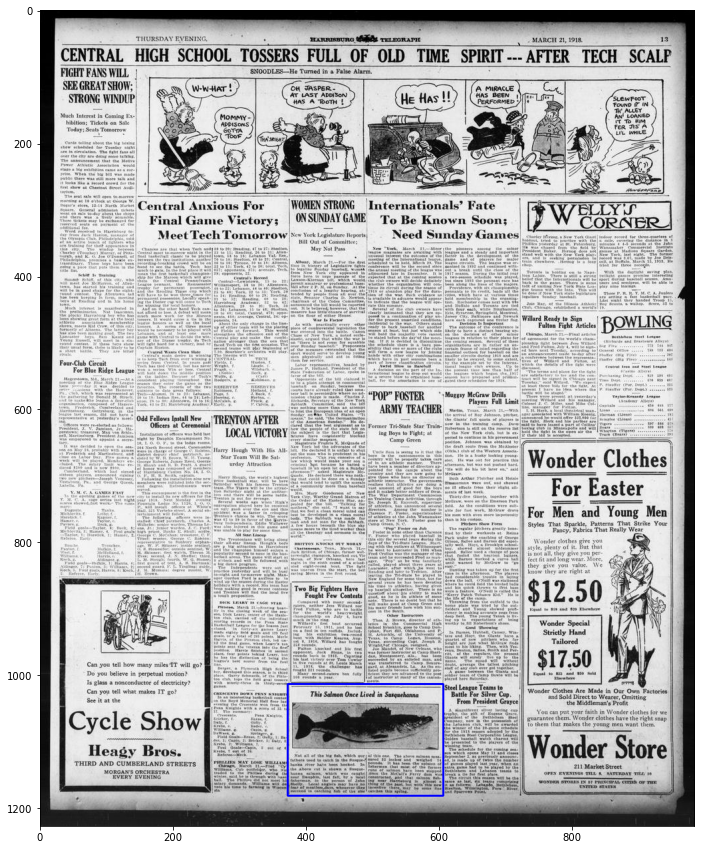

In [14]:
scaler_x, scaler_y = 5910/985, 7362/1227
x0, y0 = 2232.9839806563614, 6082.426129080048
x1, y1 = x0+1408.5957355706114, y0+1005.5406087908741

box = cv2.rectangle(
    img,
    (int(x0/scaler_x), int(y0/scaler_y)), 
    (int(x1/scaler_x), int(y1/scaler_y)), 
    (0, 0, 255), 
    thickness=2, 
)
    
fig, ax = plt.subplots(figsize=(25, 15))
ax.imshow(box, cmap='gray')

### Transformation to Gonito format:

In [15]:
output = []

for i in tqdm(range(len(repo_dictionary['data']))):
        
    baseline = repo_dictionary['data'][i]
    
    for e in range(len(jsonObject['images'])):
        if jsonObject['images'][e]['url'] == baseline['location']['standard']:
            p = jsonObject['images'][e]['id']
            break
    
    img = cv2.imread(REPO_PATH + f'beyond_words_data/images/{p}.jpg')
            
    scaler_x, scaler_y = baseline['width']/img.shape[1], baseline['height']/img.shape[0]
    
    baseline = baseline['region']
    
    x0 = baseline['x']/scaler_x
    y0 = baseline['y']/scaler_y
    x1 = (baseline['x']+baseline['width'])/scaler_x
    y1 = (baseline['y']+baseline['height'])/scaler_y
    
    output.append(f'{p}/{x0},{y0},{x1},{y1}/{1}')

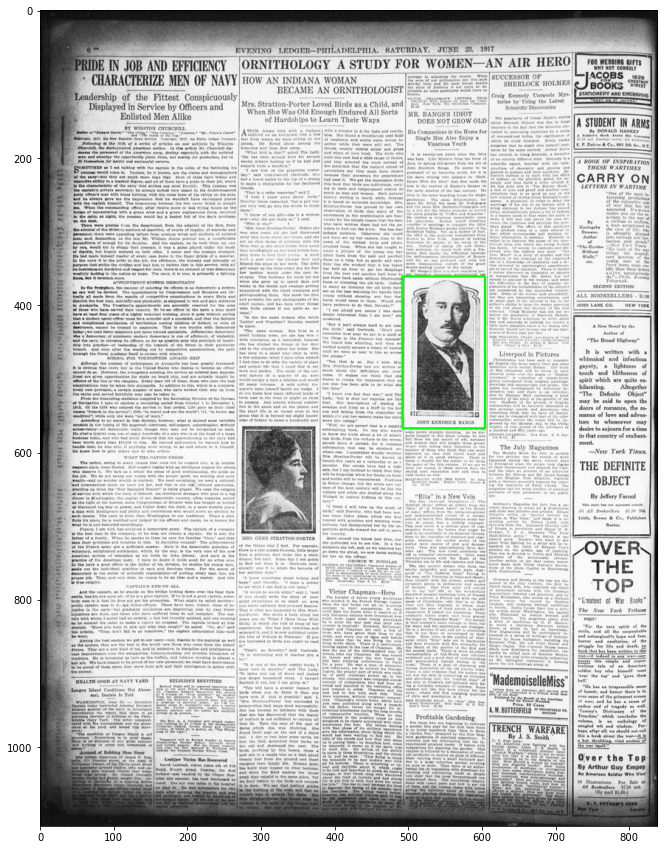

In [16]:
# checking if everything went well
random_img = random.randint(0,len(output))
variables = output[random_img].split('/')
p = variables[0]
coordinates = variables[1].split(',')
x0, y0 = float(coordinates[0]), float(coordinates[1])
x1, y1 = float(coordinates[2]), float(coordinates[3])

box = cv2.rectangle(
    cv2.imread(REPO_PATH + f'beyond_words_data/images/{p}.jpg'),
    (int(x0), int(y0)), 
    (int(x1), int(y1)), 
    (0, 255, 0), 
    thickness=2, 
)
    
fig, ax = plt.subplots(figsize=(25, 15))
ax.imshow(box, cmap='gray')

In [17]:
len(output)

6753

In [18]:
# output
output[:5]

['246/120.06086197819336,36.0923406789756,819.4567090395135,228.30503871351982/1',
 '3134/45.71265072443634,92.30830357354019,493.5297259652942,426.82004588132344/1',
 '905/-2.246827598599262,68.7607745825324,301.2536910206497,421.9740166485936/1',
 '1383/787.6548682988249,858.4322409528262,938.6239395778397,1099.904038689205/1',
 '3431/633.9029216230987,1041.9446321396601,1067.2062021556405,1451.1143407537209/1']

In [19]:
# save output to tsv file
with open('../data/gonito_format_output_6k.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    tsv_output.writerow(output)

## The same transformation but using larger json file downloaded from their website:

In [20]:
file = open("../data/bw_website_data.json", "r")

contents = file.read()
website_dictionary = ast.literal_eval(contents)

file.close()

In [21]:
len(website_dictionary['data'])

10245

In [22]:
output = []

for i in tqdm(range(len(website_dictionary['data']))):
        
    baseline = website_dictionary['data'][i]
    
    for e in range(len(jsonObject['images'])):
        if jsonObject['images'][e]['url'] == baseline['location']['standard']:
            p = jsonObject['images'][e]['id']
            break
    
    img = cv2.imread(REPO_PATH + f'beyond_words_data/images/{p}.jpg')
            
    scaler_x, scaler_y = baseline['width']/img.shape[1], baseline['height']/img.shape[0]
    
    baseline = baseline['region']
    
    x0 = baseline['x']/scaler_x
    y0 = baseline['y']/scaler_y
    x1 = (baseline['x']+baseline['width'])/scaler_x
    y1 = (baseline['y']+baseline['height'])/scaler_y
    
    output.append(f'{p}/{x0},{y0},{x1},{y1}/{1}')

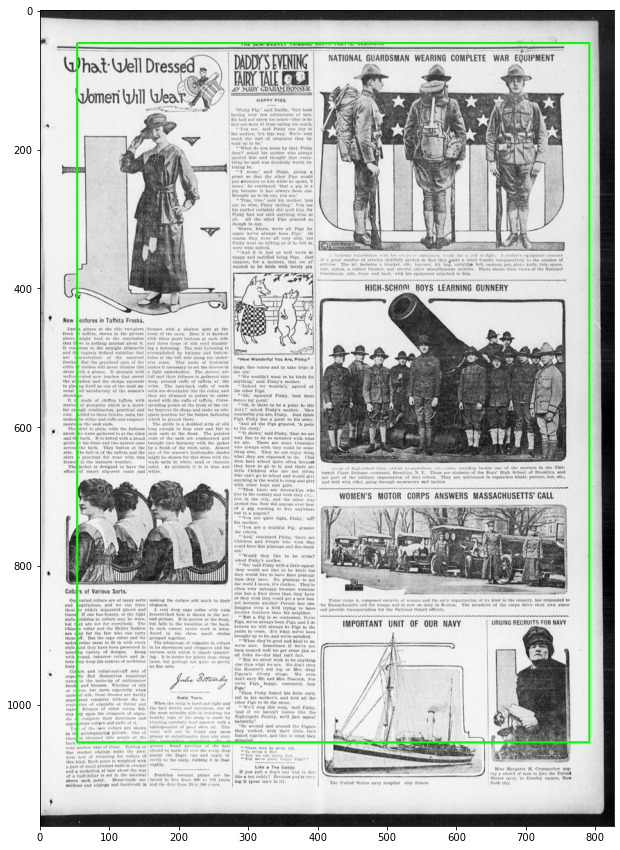

In [23]:
# checking if everything went well
random_img = random.randint(0,len(output))
variables = output[random_img].split('/')
p = variables[0]
coordinates = variables[1].split(',')
x0, y0 = float(coordinates[0]), float(coordinates[1])
x1, y1 = float(coordinates[2]), float(coordinates[3])

box = cv2.rectangle(
    cv2.imread(REPO_PATH + f'beyond_words_data/images/{p}.jpg'),
    (int(x0), int(y0)), 
    (int(x1), int(y1)), 
    (0, 255, 0), 
    thickness=2, 
)
    
fig, ax = plt.subplots(figsize=(25, 15))
ax.imshow(box, cmap='gray')

In [24]:
len(output)

10245

In [25]:
# output
output[:5]

['1373/15.50603378921963,99.54241370983215,240.68061142397428,421.4393099922764/1',
 '1373/14.141279011978822,153.70203469061386,132.13029632818214,426.39919301267065/1',
 '1373/25.421288703942075,44.04949589769222,250.58280815855866,208.15546100674163/1',
 '1373/24.94350354476201,53.10347412210022,356.63863849516287,188.51733313345576/1',
 '1373/598.6885741261243,83.62682162800199,815.1315842872528,228.36555136877467/1']

In [26]:
# save output to tsv file
with open('../data/gonito_format_output_10k.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    tsv_output.writerow(output)